In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [39]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

In [40]:
data_dir = 'data'
batch_size = 32
img_height = 45
img_width = 45

In [41]:
train_datagen = ImageDataGenerator(
    preprocessing_function=binarize)

In [42]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode="categorical",
        seed=123)

Found 170589 images belonging to 15 classes.


In [43]:
# Class names
class_names = [k for k,v in train_generator.class_indices.items()]
print(class_names)

['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'div', 'times']


In [44]:
num_classes = 15

model = tf.keras.Sequential([
  tf.keras.layers.Input((45, 45, 1)),
  tf.keras.layers.Rescaling(1./255), # originally tf.keras.layers.Rescaling
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 45, 45, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 43, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,743 (225.56 KB)

 Trainable params: 57,743 (225.56 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [47]:
model.fit(
  train_generator,
  epochs=3
)

c:\Users\M.Rismy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 783s 147ms/step - accuracy: 0.9218 - loss: 0.2876
Epoch 2/3
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 346s 65ms/step - accuracy: 0.9876 - loss: 0.0455
Epoch 3/3
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.9925 - loss: 0.0270


In [48]:
model.save('eqn-detect1 -model-without_y.keras')

In [49]:
image_dir = "equation_images/"

In [50]:
def getOverlap(a, b):
     return max(0, min(a[1], b[1]) - max(a[0], b[0]))
def detect_contours(img_path):
    # Given an image path, output bounding box coordinates of an image
    input_image = cv2.imread(img_path, 0) # Load a greyscale image
 
    # Make a copy to draw bounding box
    input_image_cpy = input_image.copy()

    # Convert the grayscale image to binary (image binarization opencv python), then invert
    binarized = cv2.adaptiveThreshold(input_image_cpy,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    inverted_binary_img = ~binarized

    # Detect contours
    # hierarchy variable contains information about the relationship between each contours
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE) # Find contours
    # Detect contours
    l = []
    for c in contours_list:
        x, y, w, h = cv2.boundingRect(c)
        l.append([x, y, w, h])
    # Check whether any overlapping rectangles. We do this in a way such that we only compare each box once with all other boxes.
    lcopy = l.copy()
    keep = []
    while len(lcopy) != 0:
        curr_x, curr_y, curr_w, curr_h = lcopy.pop(0) # Look at next box
        if curr_w * curr_h < 30: # remove very small boxes
            continue
        throw = []
        for i, (x, y, w, h) in enumerate(lcopy):
            curr_interval = [curr_x, curr_x+curr_w]
            next_interval = [x, x+w]
            if getOverlap(curr_interval, next_interval) > 1 : # more than 3 pixels overlap, this is arbitrary
                # Merge the two intervals
                new_interval_x = [min(curr_x, x), max(curr_x+curr_w, x+w)]
                new_interval_y = [min(curr_y, y), max(curr_y+curr_h, y+h)]
                newx, neww = new_interval_x[0], new_interval_x[1] - new_interval_x[0]
                newy, newh = new_interval_y[0], new_interval_y[1] - new_interval_y[0]
                curr_x, curr_y, curr_w, curr_h = newx, newy, neww, newh
                throw.append(i) # Mark this box to throw away later, since it has now been merged with current box
        for ind in sorted(throw, reverse=True): # Sort in reverse order otherwise we will pop incorrectly
            lcopy.pop(ind)
        keep.append([curr_x, curr_y, curr_w, curr_h]) # Keep the current box we are comparing against
    return keep

In [76]:
flag = 1#flag =1 for handwritten images,0 for drawn images
IMAGE = "output2.png"
img_path = "equation_images/"+IMAGE
#plt.imshow(img_path)
#plt.show()


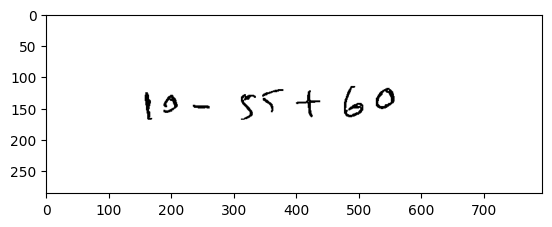

8


In [77]:
if flag == 1:
    input_image = cv2.imread(img_path) 
    ret, bw_img = cv2.threshold(input_image,127,255,cv2.THRESH_BINARY)
    plt.imshow(bw_img)
    plt.show()
    
    cv2.imwrite('equation_images/savedimage.jpg', bw_img)

    input_image_cpy = bw_img.copy()
    keep = detect_contours(image_dir+'savedimage.jpg')
    print(len(keep))
    img_path = image_dir+'savedimage.jpg'
else:
    input_image = cv2.imread(img_path, 0) 
    input_image_cpy = input_image.copy()
    keep = detect_contours(image_dir+IMAGE)
    print(len(keep))


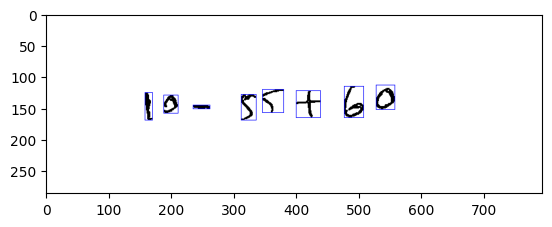

In [78]:

#Visualise how the bounding boxes look like
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_cpy, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(input_image_cpy, cmap='gray')
plt.show()

In [62]:
def resize_pad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [57]:
# Load model
new_model = tf.keras.models.load_model('eqn-detect1 -model-without_y.keras')

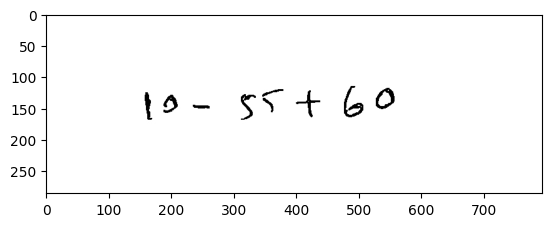

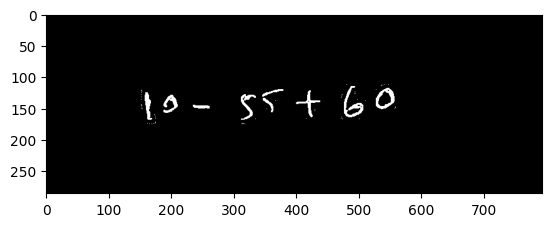

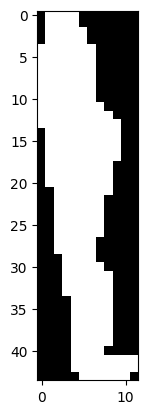

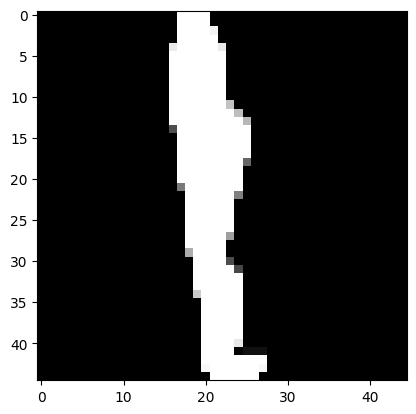

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4


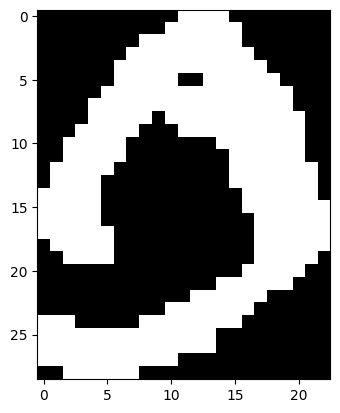

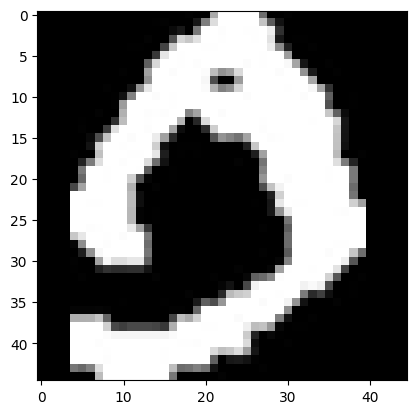

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0


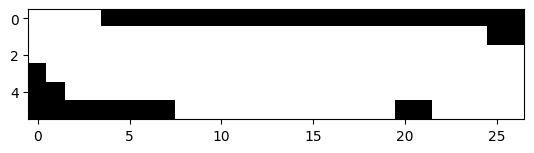

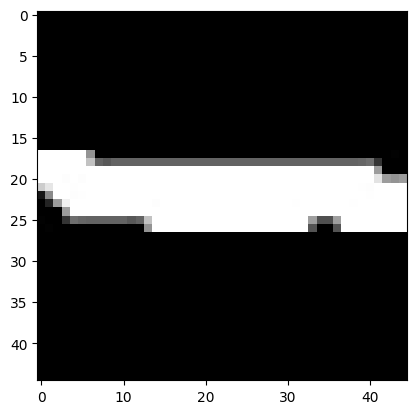

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
+


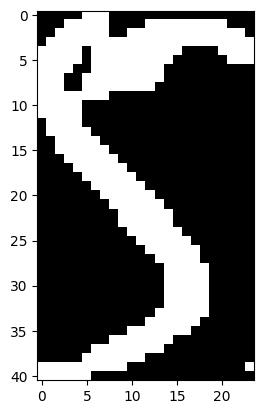

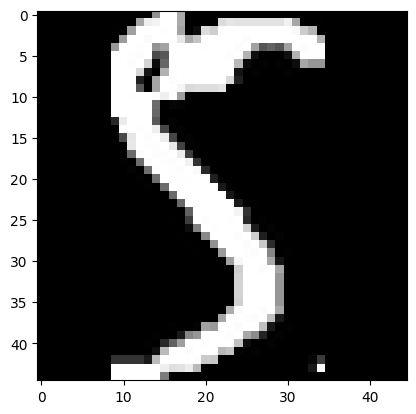

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5


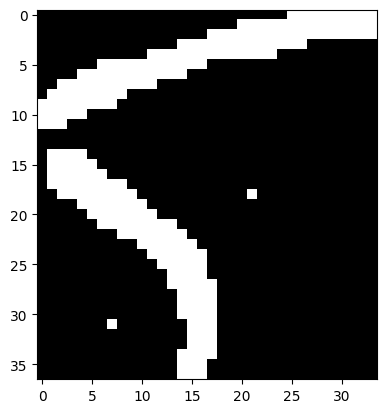

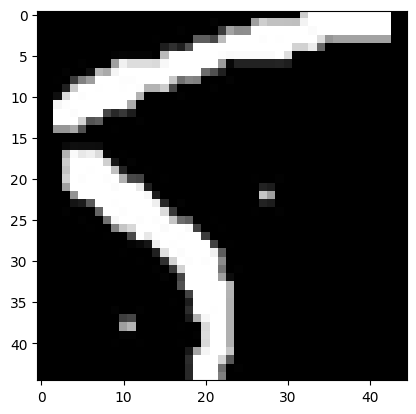

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5


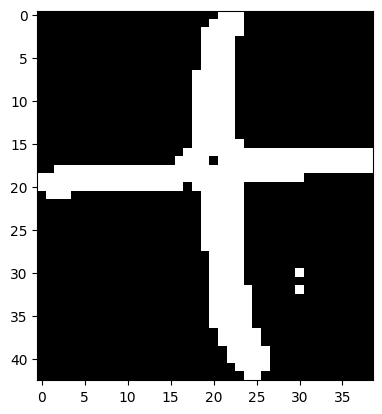

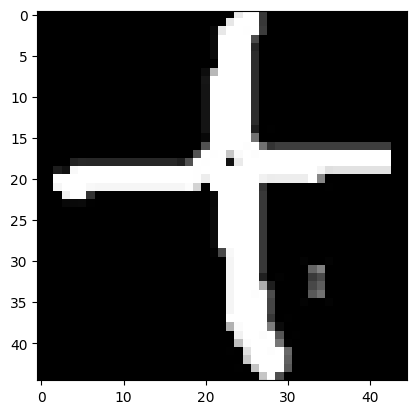

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
+


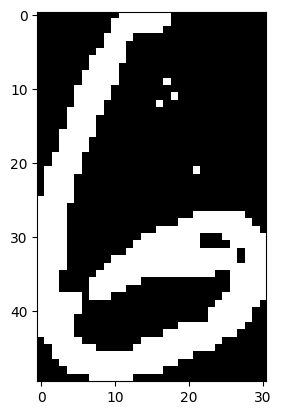

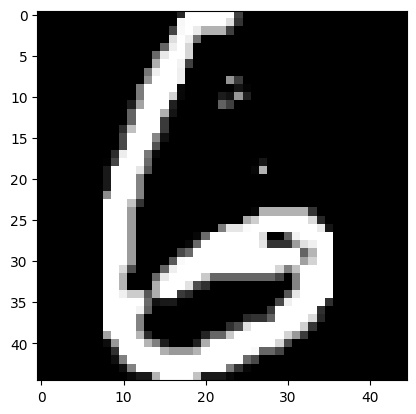

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4


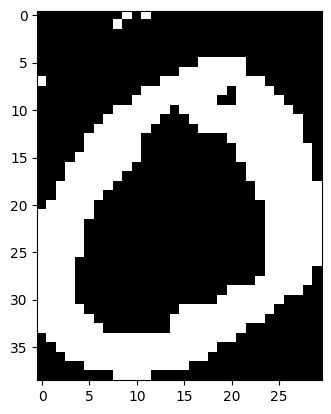

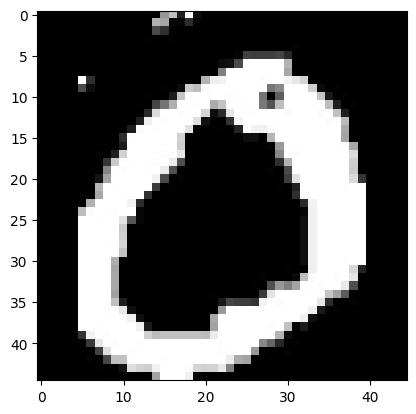

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0
40+55+40


In [79]:
eqn_list = []

# binarize the input image
#IMAGE = "testing.png"
#img_path = "equation_images/"+IMAGE
input_image = cv2.imread(img_path, 0) 
inverted_binary_img = binarize(input_image)
plt.imshow(input_image,cmap = 'gray')
#cv2.waitKey(0)
plt.show()
plt.imshow(inverted_binary_img,cmap = 'gray')
plt.show()
#cv2.imshow('res1',inverted_binary_img)
#cv2.waitKey(0)

for (x, y, w, h) in sorted(keep, key = lambda x: x[0]):
    #cv2.imshow('res',inverted_binary_img[y:y+h, x:x+w])
    #cv2.waitKey(0)
    plt.imshow(inverted_binary_img[y:y+h, x:x+w],cmap = 'gray')
    plt.show()
    

    img = resize_pad(inverted_binary_img[y:y+h, x:x+w], (45, 45), 0) # We must use the binarized image to predict
    plt.imshow(img,cmap = 'gray')
    plt.show()
    pred_class = class_names[np.argmax(new_model.predict(tf.expand_dims(tf.expand_dims(img, 0), -1)))]
    if pred_class == "times":
        pred_class = "*"
    eqn_list.append(pred_class)
    print(pred_class)
    #plt.imshow(img)
    #plt.show()
eqn = "".join(eqn_list)
print(eqn)

In [64]:
eval(eqn[2:])

NameError: name 'div76' is not defined